In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import fmplib as fmp

In [2]:
#get audio
snd1 = fmp.load_wav('wav/Twinkle1.wav')

In [3]:
#make stft with hanning window (N=4096, H=1024, zp factor = 4)
#plot stft
N = 4096
H = 1024
fs = 22050
X = fmp.stft(snd1, N, H, zp_factor=4)
X = np.log10(1+10*X)

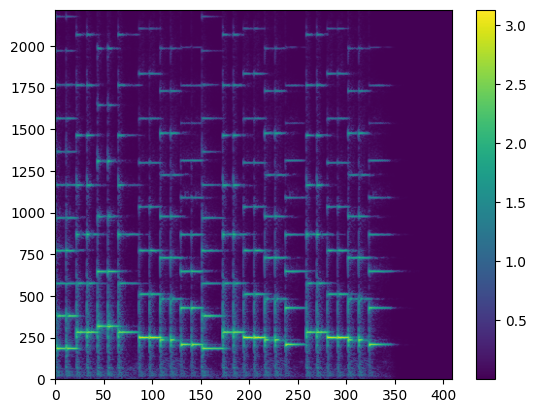

In [4]:
#consider k within k range wanted
k_max = round(N*12000/fs)
k_min = round(N*65/fs) #C2 for now
plt.imshow(abs(X[k_min:k_max+1, :]), origin='lower', aspect='auto')
plt.colorbar()

C:\Users\my537\AppData\Local\Temp\ipykernel_492\2433563012.py:8: RuntimeWarning: divide by zero encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)
C:\Users\my537\AppData\Local\Temp\ipykernel_492\2433563012.py:8: RuntimeWarning: invalid value encountered in divide
  return abs((abs(stft)-abs(shift_stft))/shift_stft)


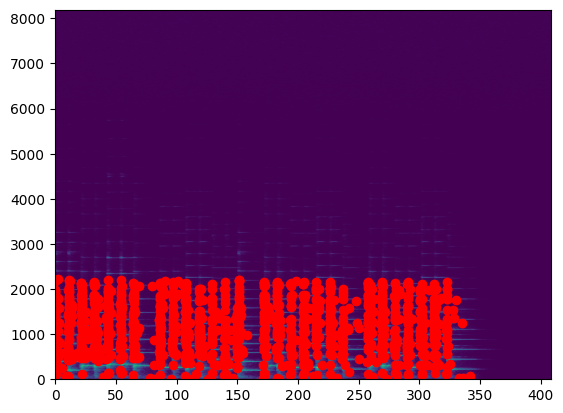

In [5]:
#calculate tonality at k
def tonality(stft):
    return amp_tonality(stft)*peak_tonality(stft, 8)
    pass

def amp_tonality(stft):
    shift_stft = np.pad(stft[:, :-1], ((0, 0), (1, 0)), mode='constant', constant_values=0)
    return abs((abs(stft)-abs(shift_stft))/shift_stft)

def peak_tonality(stft, m):
    pad_stft = np.pad(stft, ((m, m), (0, 0)), mode='constant', constant_values=0)
    return (abs(pad_stft[:len(stft),:])-abs(pad_stft[2*m:,:]))/abs(stft)

def find_intersection(matrix1, matrix2):
    set1 = set(map(tuple, matrix1))
    set2 = set(map(tuple, matrix2))
    return np.array(list(set1 & set2)).T

T = tonality(X)
#get T threshold and area peaks
temp_peaks = np.array(np.where((T > .7) & (abs(X) > .001*np.max(abs(X)))))
area_peaks = fmp.find_area_peaks(abs(X), 16, 4).T #arbitrary
area_peaks[[0, 1]] = area_peaks[[1, 0]] #same 'values' at 0 and 1
T_peaks = find_intersection(area_peaks.T, temp_peaks.T)

#get k threshold
thresh_i = np.where((T_peaks[0] >= k_min) & (T_peaks[0] <= k_max))
T_peaks = T_peaks[:, thresh_i[0]]

plt.imshow(abs(X), origin='lower', aspect='auto')
plt.plot(T_peaks[1], T_peaks[0]-k_min, 'ro')

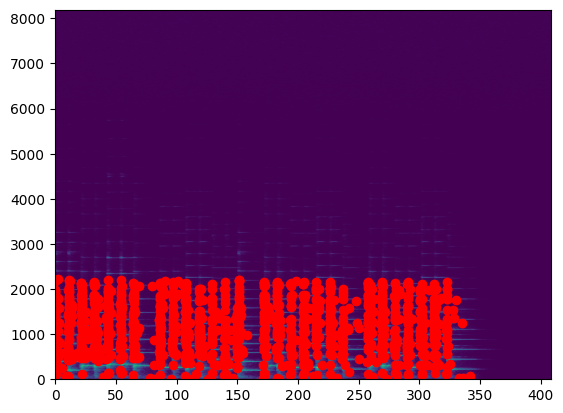

In [27]:
sal_stft = X**.25
def calc_spectral_sal(t_peaks, stft):
    #also do local max instead
    vals = stft[t_peaks[0], t_peaks[1]] + stft[2*t_peaks[0], t_peaks[1]] + stft[3*t_peaks[0], t_peaks[1]]
    threshold = .1**25*np.max(vals) #change later?
    return t_peaks.T[vals > threshold]
    pass

spectral_sal = calc_spectral_sal(T_peaks, sal_stft).T #same dim as T_peaks
plt.imshow(abs(X), origin='lower', aspect='auto')
plt.plot(spectral_sal[1], spectral_sal[0]-k_min, 'ro')

In [28]:
import scipy.signal as signal

#some pre-whitening
def smoothing(x, alpha):
    smooth_x = np.zeros(len(x))
    smooth_x[0] = x[0]
    for n in range(1, len(x)): #smooth one direction
        smooth_x[n] = alpha*x[n] + (1-alpha)*smooth_x[n-1]

    for n in range(len(x)-2, -1, -1): #smooth other direction
        smooth_x[n] = alpha*smooth_x[n] + (1-alpha)*smooth_x[n+1]

    return smooth_x

def make_MCACF(shape, c):
    W_c_1d = np.arange(shape[0]).astype(float) #has all k values
    k_c = k_min*2**c

    W_c_1d[:round(k_c/4+.5)] = 0
    W_c_1d[round(k_c/4+.5):k_c] = 4/(3*k_c)*np.arange(round(k_c/4+.5), k_c)-1/3
    W_c_1d[k_c: 2*k_c+1] = 1
    W_c_1d[2*k_c+1:20*k_c] = -1/(18*k_c)*np.arange(2*k_c+1, 20*k_c)+10/9
    W_c_1d[20*k_c:] = 0

    # W_c = np.repeat(W_c_1d[:, np.newaxis], shape[1], axis=1)
    return W_c_1d[:, np.newaxis]

def make_W_c(num):
    W_c = []
    for c in range(num):
        temp_prime = make_MCACF(X.shape, c)
        # W_c.append(temp_prime/sum(temp_prime[:, 0])) #different sum?
        W_c.append(temp_prime/sum(temp_prime)) #different sum? should this be 2d?
    return W_c

def make_e(x, p):
    L = len(x)
    new_x = np.pad(x, (1, p-1))
    S = np.hstack([np.roll(new_x, i).reshape(-1, 1) for i in range(p)])
    S_cov = S[p-1:L-1, :]
    s_cov = x[p:]
    R_hat_p = (S_cov.conj().T) @ S_cov
    r_hat_p = (S_cov.conj().T) @ s_cov
    alpha_p = np.linalg.pinv(R_hat_p) @ r_hat_p
    print('hi')

    a = np.pad(-alpha_p, (1, 0), 'constant', constant_values=(1, 1))
    e_p = s_cov - S_cov@alpha_p
    epsilon = np.abs(e_p.conj().T @ e_p)
    G = np.sqrt(epsilon)

    w, h = signal.freqz(b=G, a=a, worN=N)
    return h

def make_E(full_x, p, shape):
    E = np.zeros(shape)
    ks = np.arange(N)
    hann = np.hanning(N)
    for n in range(shape[1]):
        try:
            temp = full_x[H*n: H*n+N]*hann
        except:
            temp = np.pad(full_x[H*n:], (0, N-len(full_x)+H*n))*hann
        temp = np.pad(temp, (0, shape[0]-N))
        coeffs = make_e(temp, p)
        log_space_coeffs = np.interp(10**ks, ks, coeffs)
        smoothed_coeffs = smoothing(log_space_coeffs, 20/N)
        E[:N, n] = np.interp(np.log10(ks), ks, smoothed_coeffs)
    return E
    

p = len(spectral_sal[0])
# E = make_E(snd1, p, X.shape)
# X_w_prime = X/E
X_w_prime = X/np.ones(X.shape)

#might be sus
# print(np.sqrt(np.sum(X[:k_max, :]**2)/np.sum(X_w_prime[:k_max, :]**2)))
X_w1 = X_w_prime * np.sqrt(np.sum(X[:k_max, :]**2)/np.sum(X_w_prime[:k_max, :]**2)) #sqrt is a number

W_c = make_W_c(5)

In [29]:
def make_A_c(X, W_c, N, H):
    A_c = []
    for c in range(len(W_c)):
        val = np.sqrt(N*X**2)*W_c[c]
        # A_c.append(fmp.istft(val, H))
        A_c.append(np.fft.ifft2(val))
    return A_c

def find_A_peaks(a_c, c):
    temp_peaks = fmp.find_area_peaks(abs(a_c), 8, 8) #x, y
    temp_peaks[:, [0, 1]] = temp_peaks[:, [1, 0]] #y, x
    thresh = .001*np.max(a_c[1:, :])
    temp_peaks = temp_peaks[a_c[temp_peaks[:, 0], temp_peaks[:, 1]] > thresh]
    m_max = np.max(temp_peaks[:, 0])
    range_i = np.where((2**(-c)*m_max >= temp_peaks[:, 0]) & (2**(-c-1)*m_max <= temp_peaks[:, 0]))
    range_peaks = temp_peaks[range_i[0]]
    return range_peaks.T

A_c = make_A_c(X_w1, W_c, N, H)
# plt.plot(abs(A_c[2][:, 200]))
A_peaks = [find_A_peaks(A_c[c], c) for c in range(5)]
print(len(A_peaks[2]))
# A_peaks = combine_A_peaks(A_peaks_prime)
#black box of finding official A_peaks

2


In [31]:
def calc_a_sal(a_peaks, a_c):
    #also do local max instead
    a_sal = a_c[a_peaks[0], a_peaks[1]] + a_c[2*a_peaks[0], t_peaks[1]] + a_c[3*a_peaks[0], t_peaks[1]]
    return a_sal

# A_c_sal 

In [ ]:
def make_Q_a_c(a_peaks):
    Q_a = np.zeros(a_peaks.shape)
    # Q_a[0] = np.round(36+2**((fs*a_peaks[0])/65.406))
    print(a_peaks)
    Q_a[0] = np.round(69+np.log2(1/(440*a_peaks[0])))
    # print(Q_a[0])
    Q_a[1] = a_peaks[1]*1

def k_to_bin(k_vals):
    freqs = k_vals*fs/N
    return np.round(fmp.freq_to_pitch(freqs))

Q_x = np.zeros(spectral_sal.shape)
Q_x[0] = k_to_bin(spectral_sal[0])
Q_x[1] = spectral_sal[1]*1

Q_a = [make_Q_a_c(A_peaks[2]) for c in range(1)]

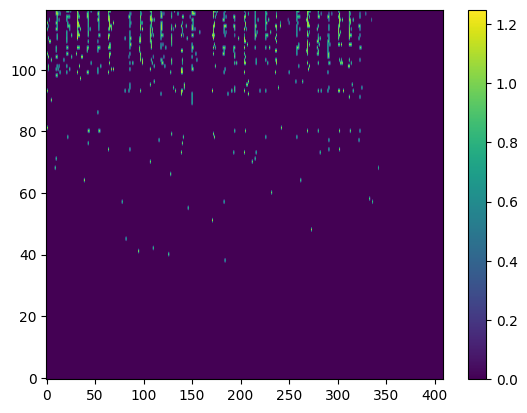

In [26]:
def make_Q_x_sal(q_x, peaks, sal_stft):
    #along each time bin (np.where to isolate n values):
    #turn this n into something of length 12000
    #for items with only one MIDI value, assign S_q(q, n) to relevant sal_stft(k, n)
    #for k's that overlap into one MIDI value, assign S_q(k, n) to the max 
    #return something of size of (wanted MIDI values, n)
    Q_x_sal = np.zeros((12001, sal_stft.shape[1]))
    for n in np.unique(peaks[1]):
        found_q = q_x[0][np.where(q_x[1] == n)]
        for q in found_q:
            #np where
            found_k = peaks[0][np.where((q_x[1] == n) & (q_x[0] == q))]
            if len(found_k) > 1:
                pass #assign S_q(k, n) to the max salience
                best_k = found_k[np.argmax(sal_stft[found_k, n])]
                Q_x_sal[int(q), n] = abs(sal_stft[best_k, n])
            else:
                pass #assign S_q(q, n) to relevant sal_stft(k, n)
                Q_x_sal[int(q), n] = abs(sal_stft[found_k[0], n])
            
    return Q_x_sal
    pass

def make_Q_a_sal(q_a, peaks, sal_stft): #autocorrleation
    for c in range(len(q_a)):
        pass
    #return something of size of (wanted MIDI values, n)
    pass
    return np.zeros((12001, sal_stft.shape[1]))

S_Q_x = make_Q_x_sal(Q_x, spectral_sal, sal_stft)
plt.imshow(S_Q_x[:120, :], aspect='auto', origin='lower')
# plt.plot(Q_x[1], Q_x[0], 'ro')
plt.colorbar()
S_Q_a = make_Q_a_sal(Q_a, A_peaks, sal_stft) #wrong stft
S_Q = S_Q_x*S_Q_a